In [1]:
import os
import os.path
import pickle

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [2]:
NOTE = '全特徴量を使用したCatBoost.バランス指定、カテゴリ指定'

N = 5
CV = f'Stratified-Kfold(K={N})'

notebook_name = '019'
OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1
CATEGORICAL_FEATURES =  [
        'batterID', 'pitcherID', 'Match',
        'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher',
        'isBottom', 'batterTeam', 'pitcherTeam'
    ]

019_submission.csv 019


In [3]:
def get_estimator(*,
                  categorical_features=None,
                  discrete_features=None,
                  features=None) -> Pipeline:
    
    '''How to calculate:
    from sklearn.utils.class_weight import compute_class_weight
    
    ## <Load train set> ##
    
    compute_class_weight('balanced', classes=np.sort(train.y.unique()), y=train.y)
    '''
    class_weights = {
        0: 0.33822833,
        1: 0.4574968, 
        2: 0.71590909,
        3: 1.00280899,
        4: 3.17333333,
        5: 11.45454545,
        6: 194.72727273,
        7: 17.85
    }
    clf = CatBoostClassifier(n_estimators=200,
                             class_weights=class_weights,
                             cat_features=categorical_features,
                             learning_rate=0.01,
                             random_state=SEED)
    clf.set_feature_names = features
    return Pipeline(steps=[
        ('estimator', clf)
         ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
# for c in CATEGORICAL_FEATURES:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])

# train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
# test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)

# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

In [6]:
# categorical_features = []
# for c in CATEGORICAL_FEATURES:
#     categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
categorical_features = CATEGORICAL_FEATURES
categorical_features

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam']

In [7]:
features = [c for c in train.columns if c not in ('id', 'y')]
assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
discrete_features = [f for f in features if f not in categorical_features]
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'b1',
 'b2',
 'b3',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabe

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )
    clf = get_estimator()
    clf.fit(X_train, y_train.values)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



0:	learn: 2.0727635	total: 420ms	remaining: 1m 23s
1:	learn: 2.0663508	total: 656ms	remaining: 1m 4s
2:	learn: 2.0624538	total: 915ms	remaining: 1m
3:	learn: 2.0572024	total: 1.15s	remaining: 56.2s
4:	learn: 2.0538580	total: 1.38s	remaining: 53.9s
5:	learn: 2.0482119	total: 1.61s	remaining: 52.2s
6:	learn: 2.0437798	total: 1.85s	remaining: 51s
7:	learn: 2.0402412	total: 2.09s	remaining: 50.1s
8:	learn: 2.0353641	total: 2.31s	remaining: 49s
9:	learn: 2.0315893	total: 2.54s	remaining: 48.3s
10:	learn: 2.0258964	total: 2.79s	remaining: 47.9s
11:	learn: 2.0244271	total: 3.04s	remaining: 47.6s
12:	learn: 2.0195961	total: 3.3s	remaining: 47.5s
13:	learn: 2.0167782	total: 3.57s	remaining: 47.4s
14:	learn: 2.0128427	total: 3.81s	remaining: 47s
15:	learn: 2.0086737	total: 4.06s	remaining: 46.7s
16:	learn: 2.0043619	total: 4.3s	remaining: 46.3s
17:	learn: 2.0006968	total: 4.53s	remaining: 45.8s
18:	learn: 1.9979864	total: 4.76s	remaining: 45.4s
19:	learn: 1.9956469	total: 5s	remaining: 45s
20:	l

162:	learn: 1.6821113	total: 1m	remaining: 13.7s
163:	learn: 1.6801301	total: 1m	remaining: 13.4s
164:	learn: 1.6780794	total: 1m 1s	remaining: 13s
165:	learn: 1.6760212	total: 1m 1s	remaining: 12.6s
166:	learn: 1.6743303	total: 1m 2s	remaining: 12.3s
167:	learn: 1.6727978	total: 1m 2s	remaining: 11.9s
168:	learn: 1.6718597	total: 1m 2s	remaining: 11.5s
169:	learn: 1.6701655	total: 1m 3s	remaining: 11.2s
170:	learn: 1.6690554	total: 1m 3s	remaining: 10.8s
171:	learn: 1.6675861	total: 1m 4s	remaining: 10.4s
172:	learn: 1.6661202	total: 1m 4s	remaining: 10s
173:	learn: 1.6646265	total: 1m 4s	remaining: 9.67s
174:	learn: 1.6630022	total: 1m 5s	remaining: 9.3s
175:	learn: 1.6611345	total: 1m 5s	remaining: 8.93s
176:	learn: 1.6597154	total: 1m 5s	remaining: 8.57s
177:	learn: 1.6586798	total: 1m 6s	remaining: 8.21s
178:	learn: 1.6564989	total: 1m 6s	remaining: 7.84s
179:	learn: 1.6552644	total: 1m 7s	remaining: 7.47s
180:	learn: 1.6535906	total: 1m 7s	remaining: 7.11s
181:	learn: 1.6520443	t

108:	learn: 1.7789694	total: 41s	remaining: 34.3s
109:	learn: 1.7766842	total: 41.4s	remaining: 33.9s
110:	learn: 1.7751763	total: 41.8s	remaining: 33.5s
111:	learn: 1.7731117	total: 42.2s	remaining: 33.2s
112:	learn: 1.7705862	total: 42.6s	remaining: 32.8s
113:	learn: 1.7695680	total: 43s	remaining: 32.4s
114:	learn: 1.7673418	total: 43.3s	remaining: 32s
115:	learn: 1.7657853	total: 43.7s	remaining: 31.7s
116:	learn: 1.7647787	total: 44.1s	remaining: 31.3s
117:	learn: 1.7635328	total: 44.4s	remaining: 30.9s
118:	learn: 1.7619329	total: 44.8s	remaining: 30.5s
119:	learn: 1.7606111	total: 45.3s	remaining: 30.2s
120:	learn: 1.7587953	total: 45.6s	remaining: 29.8s
121:	learn: 1.7579331	total: 46s	remaining: 29.4s
122:	learn: 1.7566108	total: 46.3s	remaining: 29s
123:	learn: 1.7541294	total: 46.7s	remaining: 28.6s
124:	learn: 1.7516886	total: 47s	remaining: 28.2s
125:	learn: 1.7495757	total: 47.4s	remaining: 27.8s
126:	learn: 1.7476986	total: 47.9s	remaining: 27.5s
127:	learn: 1.7464883	to

53:	learn: 1.9002326	total: 20.1s	remaining: 54.3s
54:	learn: 1.8989215	total: 20.4s	remaining: 53.9s
55:	learn: 1.8958418	total: 20.9s	remaining: 53.6s
56:	learn: 1.8938153	total: 21.3s	remaining: 53.4s
57:	learn: 1.8905745	total: 21.7s	remaining: 53.1s
58:	learn: 1.8873105	total: 22.1s	remaining: 52.8s
59:	learn: 1.8847846	total: 22.4s	remaining: 52.3s
60:	learn: 1.8809479	total: 22.8s	remaining: 52s
61:	learn: 1.8783116	total: 23.2s	remaining: 51.7s
62:	learn: 1.8756393	total: 23.6s	remaining: 51.3s
63:	learn: 1.8723878	total: 24s	remaining: 50.9s
64:	learn: 1.8705152	total: 24.4s	remaining: 50.6s
65:	learn: 1.8674201	total: 24.8s	remaining: 50.3s
66:	learn: 1.8656600	total: 25.2s	remaining: 49.9s
67:	learn: 1.8640213	total: 25.6s	remaining: 49.6s
68:	learn: 1.8606964	total: 25.9s	remaining: 49.2s
69:	learn: 1.8587138	total: 26.3s	remaining: 48.9s
70:	learn: 1.8561171	total: 26.7s	remaining: 48.5s
71:	learn: 1.8534370	total: 27.1s	remaining: 48.1s
72:	learn: 1.8508387	total: 27.5s	r

0:	learn: 2.0724788	total: 435ms	remaining: 1m 26s
1:	learn: 2.0683923	total: 799ms	remaining: 1m 19s
2:	learn: 2.0638455	total: 1.21s	remaining: 1m 19s
3:	learn: 2.0579678	total: 1.69s	remaining: 1m 22s
4:	learn: 2.0555003	total: 2.07s	remaining: 1m 20s
5:	learn: 2.0517361	total: 2.51s	remaining: 1m 21s
6:	learn: 2.0469310	total: 2.93s	remaining: 1m 20s
7:	learn: 2.0440188	total: 3.37s	remaining: 1m 20s
8:	learn: 2.0388067	total: 3.8s	remaining: 1m 20s
9:	learn: 2.0350596	total: 4.2s	remaining: 1m 19s
10:	learn: 2.0308455	total: 4.6s	remaining: 1m 19s
11:	learn: 2.0249106	total: 4.97s	remaining: 1m 17s
12:	learn: 2.0211904	total: 5.32s	remaining: 1m 16s
13:	learn: 2.0161471	total: 5.75s	remaining: 1m 16s
14:	learn: 2.0108411	total: 6.16s	remaining: 1m 16s
15:	learn: 2.0058808	total: 6.58s	remaining: 1m 15s
16:	learn: 2.0016821	total: 6.88s	remaining: 1m 14s
17:	learn: 1.9982435	total: 7.24s	remaining: 1m 13s
18:	learn: 1.9944043	total: 7.54s	remaining: 1m 11s
19:	learn: 1.9921431	tota

161:	learn: 1.6831329	total: 1m 2s	remaining: 14.6s
162:	learn: 1.6813626	total: 1m 2s	remaining: 14.2s
163:	learn: 1.6805729	total: 1m 2s	remaining: 13.8s
164:	learn: 1.6786769	total: 1m 3s	remaining: 13.4s
165:	learn: 1.6775537	total: 1m 3s	remaining: 13s
166:	learn: 1.6766764	total: 1m 4s	remaining: 12.7s
167:	learn: 1.6748654	total: 1m 4s	remaining: 12.3s
168:	learn: 1.6736129	total: 1m 4s	remaining: 11.9s
169:	learn: 1.6721260	total: 1m 5s	remaining: 11.5s
170:	learn: 1.6702438	total: 1m 5s	remaining: 11.1s
171:	learn: 1.6687812	total: 1m 6s	remaining: 10.8s
172:	learn: 1.6666423	total: 1m 6s	remaining: 10.4s
173:	learn: 1.6650634	total: 1m 6s	remaining: 10s
174:	learn: 1.6630924	total: 1m 7s	remaining: 9.61s
175:	learn: 1.6622092	total: 1m 7s	remaining: 9.22s
176:	learn: 1.6609469	total: 1m 8s	remaining: 8.84s
177:	learn: 1.6600214	total: 1m 8s	remaining: 8.46s
178:	learn: 1.6586599	total: 1m 8s	remaining: 8.07s
179:	learn: 1.6569434	total: 1m 9s	remaining: 7.69s
180:	learn: 1.65

107:	learn: 1.7730495	total: 41.6s	remaining: 35.5s
108:	learn: 1.7708816	total: 42.1s	remaining: 35.1s
109:	learn: 1.7688560	total: 42.5s	remaining: 34.8s
110:	learn: 1.7666167	total: 42.9s	remaining: 34.4s
111:	learn: 1.7648600	total: 43.2s	remaining: 34s
112:	learn: 1.7620317	total: 43.6s	remaining: 33.6s
113:	learn: 1.7602831	total: 44s	remaining: 33.2s
114:	learn: 1.7591997	total: 44.3s	remaining: 32.7s
115:	learn: 1.7579310	total: 44.7s	remaining: 32.4s
116:	learn: 1.7553717	total: 45.1s	remaining: 32s
117:	learn: 1.7526138	total: 45.5s	remaining: 31.6s
118:	learn: 1.7495211	total: 45.9s	remaining: 31.3s
119:	learn: 1.7475099	total: 46.3s	remaining: 30.9s
120:	learn: 1.7469770	total: 46.7s	remaining: 30.5s
121:	learn: 1.7454294	total: 47.1s	remaining: 30.1s
122:	learn: 1.7433438	total: 47.5s	remaining: 29.7s
123:	learn: 1.7417541	total: 47.9s	remaining: 29.3s
124:	learn: 1.7402447	total: 48.3s	remaining: 29s
125:	learn: 1.7385550	total: 48.7s	remaining: 28.6s
126:	learn: 1.737127

In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.332642,0.152007
std,0.007815,0.003561
min,0.323505,0.147700
25%,0.327184,0.150898
50%,0.332333,0.151083
75%,0.336943,0.152945
max,0.343245,0.157411


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,1,0,1
1,1,1,1,0,1
2,2,0,4,0,1
3,3,2,4,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,3,0,5
17130,16833,1,1,0,5
17133,9762,1,1,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.128823,0.126457,0.134553,0.135230,0.135604,0.141018,0.059195,0.139120,27446,1
1,0.136420,0.135880,0.140494,0.137659,0.134953,0.126389,0.065041,0.123164,113,1
2,0.149890,0.158250,0.135553,0.129627,0.125658,0.118610,0.061024,0.121388,4479,1
3,0.149897,0.158069,0.136072,0.131020,0.127244,0.119583,0.056130,0.121984,29080,1
4,0.143638,0.145414,0.144696,0.136985,0.132742,0.123000,0.057458,0.116067,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.139214,0.157673,0.150459,0.158480,0.146482,0.116976,0.050149,0.080567,24272,5
33804,0.134006,0.151738,0.154484,0.165511,0.150854,0.118846,0.049479,0.075082,29106,5
33805,0.135017,0.152709,0.154654,0.166066,0.150244,0.120911,0.046325,0.074074,20679,5
33806,0.138526,0.155844,0.152964,0.163847,0.146004,0.116376,0.049924,0.076514,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,0.751581,0.866688,0.777290,0.713772,0.665675,0.606995,0.210208,0.407791
1,1,0.736788,0.772183,0.664970,0.676429,0.647521,0.638168,0.260046,0.603895
2,2,0.630134,0.599882,0.673090,0.686015,0.709371,0.664472,0.260163,0.776873
3,3,0.692468,0.776650,0.663046,0.797324,0.721552,0.599542,0.272529,0.476889
4,4,0.740277,0.786108,0.666526,0.681154,0.645818,0.621163,0.279954,0.578999
...,...,...,...,...,...,...,...,...,...
33803,33803,0.732391,0.712010,0.718334,0.687208,0.700348,0.663762,0.257276,0.528672
33804,33804,0.691238,0.707396,0.636626,0.728255,0.691697,0.586571,0.294063,0.664154
33805,33805,0.657014,0.649673,0.577424,0.627270,0.626412,0.597610,0.351811,0.912786
33806,33806,0.675946,0.760312,0.752129,0.790095,0.751309,0.667666,0.236485,0.366058


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,7
3,3,3
4,4,1
...,...,...
33803,33803,0
33804,33804,3
33805,33805,7
33806,33806,3


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.039074
1    0.413541
2    0.081785
3    0.259968
4    0.014139
5    0.011003
7    0.180490
Name: y, dtype: float64

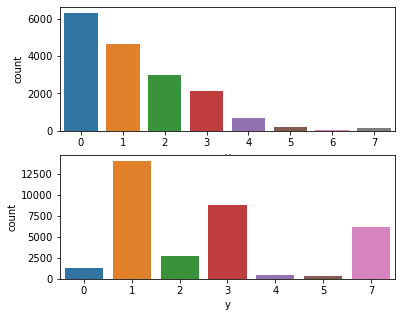

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.33264188916606263, 0.15200742421234442)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"019_submission.csv","Stratified-Kfold(K=5)","0.332642","0.152007","","全特徴量を使用したCatBoost.バランス指定、カテゴリ指定"


In [19]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 33 ms


In [20]:
%%time
imp_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        else:
            feature_names = final_estimator.feature_names_
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 46 ms
